# LUS-CS433

## 1. Code Exploration

### Imports

In [ ]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sns

### Downloading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/My\ Drive/ppredictus_images.zip

In [ ]:
image_dataset = datasets.ImageFolder('LUS images')

In [ ]:
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=4,
                                             shuffle=True, num_workers=4)

In [ ]:
dataset_size = len(image_dataset)
class_names = image_dataset.classes

In [ ]:
class_names

['negative', 'positive']

## 2. Data Exploration

In [ ]:
diagnostics = pd.read_csv('labels_diagnostic.csv')

In [ ]:
# getting the list of names
!ls LUS\ images/negative > neg_names.csv
!ls LUS\ images/positive > pos_names.csv

neg = pd.read_csv('neg_names.csv', header=None)
pos = pd.read_csv('pos_names.csv', header=None)

data = neg.append(pos, ignore_index=True)
data

,0
0,100_QAID_1.png
1,100_QAID_2.png
2,100_QAIG_1.png
3,100_QAIG_2.png
4,100_QASD_1.png
...,...
3582,final_9_QPIG_2.png
3583,final_9_QPSD_1.png
3584,final_9_QPSD_2.png
3585,final_9_QPSG_1.png


In [ ]:
pos = pd.read_csv('pos_names.csv', header=None)

# removing .png extension
pos[0] = pos[0].apply(lambda x: x[:-4])

# extracting site
pos[0] = pos[0].apply(lambda x: x.split('_')[2])

pos

,0
0,QAID
1,QAID
2,QAIG
3,QAIG
4,QASD
...,...
2337,QPIG
2338,QPSD
2339,QPSD
2340,QPSG


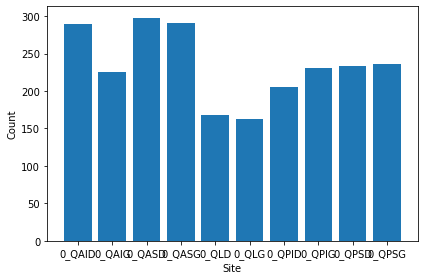

In [ ]:
sums = pd.get_dummies(pos).sum()

plt.bar(sums.index, sums.values)
plt.xlabel('Site')
plt.ylabel('Count')
plt.tight_layout()

## 3. Apply mask on Data and sort files

In [ ]:
! mkdir LUS_proc_images
! mkdir LUS_proc_images/train
! mkdir LUS_proc_images/val
! mkdir LUS_proc_images/train/true
! mkdir LUS_proc_images/train/false
! mkdir LUS_proc_images/val/true
! mkdir LUS_proc_images/val/false 

In [ ]:
import cv2

In [ ]:
x = cv2.imread('LUS images/negative/117_QAIG_1.png')

In [ ]:
nb_rows, nb_cols, rgb = x.shape
nb_cols791 = 791
print(nb_rows, nb_cols)

1080 804


In [ ]:
for row in range(nb_rows):
  for col in range(nb_cols):
    if int((-4/5 * row + 300)) == col or int((4/5 * row + len(x[0])-300)) == col or row == 25 or row == 1010 or col == 762:
      x[row,col] = [255,0,0]

cv2.imwrite("lines_example.jpg",x)

True

In [ ]:
#Create a mask for all images
mask804 = np.zeros([1080, 804,3])
for row in range(nb_rows):
  for col in range(nb_cols):
    if row > 25 and row < 1010 and col < 762 and (-4/5 * row) + 300 < col and (4/5 * row) + len(x[0])-300 > col:
      mask804[row, col] = [1,1,1]


In [ ]:
mask791 = np.zeros([1080,791, 3])
for row in range(nb_rows):
  for col in range(nb_cols791):
    if row > 25 and row < 1010 and col < 762 and (-4/5 * row + 293) < col and (4/5*row) + len(x[0])-293 > col:
      mask791[row, col] = [1,1,1]


In [ ]:
import glob
def create_samples(num_samples, ratio, path):
  images_path = glob.glob(path)
  train = int(num_samples * ratio)

  for i, image in enumerate(images_path[:num_samples]):
    cv2_img = cv2.imread(image)
  
    if (len(cv2_img[0]) == 791):
      masked_img = cv2_img * mask791
    else:
      masked_img = cv2_img * mask804

    if i >= train:
      cv2.imwrite(f"LUS_proc_images/val/true/{image[20:]}", masked_img)
    else:
      cv2.imwrite(f"LUS_proc_images/train/true/{image[20:]}", masked_img)

In [ ]:
#Make sure that the files are empty
! rm -rfv LUS_proc_images/val/true/*
! rm -rfv LUS_proc_images/train/true/*


In [ ]:
#Generates the samples!
num_samples = 1245
ratio = 0.8
path = "LUS images/negative/*.png"

create_samples(num_samples, ratio, path)

#### Compute mean brightness over all sample

In [ ]:
def create_brightness_df(path):
  df = pd.DataFrame(columns = ['mean', 'std'])
  images_path = glob.glob(path)

  for i,image in enumerate(images_path):
    img = cv2.imread(image)
    m, s = cv2.meanStdDev(img)
    df.loc[i] = [m[0,0], s[0,0]]

  return df


In [ ]:
df = create_brightness_df("LUS_proc_images/train/true/*.png")

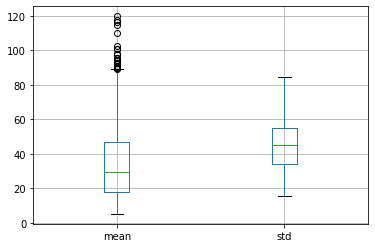

In [ ]:
df.boxplot()

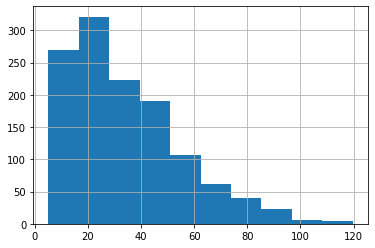

In [ ]:
df['mean'].hist()

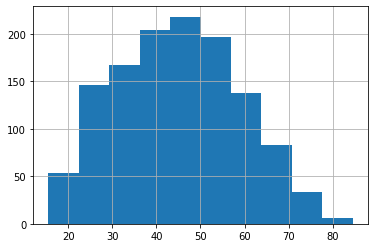

In [ ]:
df['std'].hist()

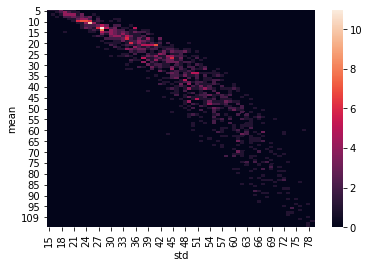

In [ ]:
df2 = df.astype(int)
df2 = pd.crosstab(df2['mean'], df2['std'])
sns.heatmap(df2)

In [ ]:
VIDEO_TITLE = "1_9_QLD.mp4"
video = cv2.VideoCapture(VIDEO_TITLE)
i = 0
df_video = pd.DataFrame(columns = ['mean', 'std'])
while(video.isOpened()):
  ret, image = video.read()
  if ret == True:
    if len(image[0]) == 791:
      image = image * mask791
    elif len(image[0]) == 804:
      image = image * mask804
    m, s = cv2.meanStdDev(image)
    df_video.loc[i] = [m[0,0], s[0,0]]
    i += 1
video.release()

KeyboardInterrupt: ignored

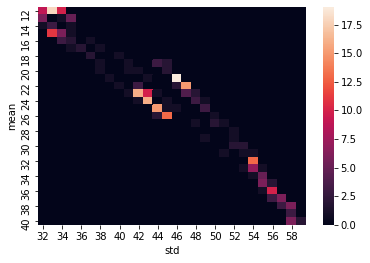

In [ ]:
df_video2 = df_video.astype(int)
df_video2 = pd.crosstab(df_video2['mean'], df_video2['std'])
sns.heatmap(df_video2)

In [ ]:
df_video.head(20)

,mean,std
0,37.864373,57.183505
1,37.115139,56.459659
2,36.875601,56.347352
3,36.314428,56.145268
4,35.674874,55.818582
5,35.115213,55.344910
6,34.517314,55.151923
7,34.099862,54.916397
8,34.293143,55.196529
9,34.775807,55.572057
